In [1]:
import sys
import pickle
from pprint import pprint
import time
import datetime

In [2]:
from qiskit import IBMQ

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_brooklyn")
device = provider.backend.ibmq_brooklyn

In [4]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_star_graph, list_to_matrix

In [5]:
vertex_list =  [19, 
                25, 
                20, 33,
                18, 21, 32,
                34, 17, 12, 31,
                22, 35, 16, 8, 39, 
                11, 30, 23, 36, 15, 7, 45,
                40, 9, 4, 29, 26, 37, 24, 6, 46,
                14, 44, 49, 3, 28, 5, 47] # qubit layout
max_size = len(vertex_list) # largest graph size
Fs = [[0] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_star_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution

In [6]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 39
shots_per_circuit: 8192


In [7]:
# indicate how to connect qubits
order = [[0,1],
         [0,2],[1,3],
         [0,4],[2,5],[3,6],
         [3,7],[4,8],[5,9],[6,10],
         [5,11],[7,12],[8,13],[9,14],[10,15],
         [8,16],[10,17],[11,18],[12,19],[13,20],[14,21],[15,22],
         [12,23],[14,24],[16,25],[17,26],[18,27],[19,28],[20,29],[21,30],[22,31],
         [20,32],[22,33],[23,34],[25,35],[26,36],[30,37],[31,38]]

In [8]:
from lib_graph_states import star_graph_state
qcs = [star_graph_state(size, order[:size-1]) for size in range(1, max_size+1)]
print(len(qcs), "qcs")

39 qcs


In [11]:
from lib_star_graphs import prepare_star_graph_qcs_list, execute_circuits

In [12]:
qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = \
    prepare_star_graph_qcs_list(qcs, 
                                backend,
                                optimization_level=3,
                                initial_layouts=[vertex_list[:qc.num_qubits] for qc in qcs])
print("the number of graph state circuits is: ", len(qcs_list))

/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


the number of graph state circuits is:  152


In [ ]:
jobs = execute_circuits(qcs_list,
                        backend=backend,
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=0)
print(len(jobs), "jobs")
print("job_id:", jobs[0].job_id())

In [ ]:
dt_now = datetime.datetime.now()
job_ids_filename = "job_ids_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [ ]:
with open("./pkls/" + job_ids_filename, "wb") as f:
    pickle.dump([job.job_id() for job in jobs], f)

In [ ]:
with open("./pkls/" + "properties_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

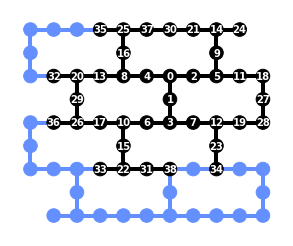

In [9]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)